## Stuff

In [1]:
from predictive_coding.analysis import *
from predictive_coding import PredictiveCoder, VestibularCoder, BottleneckCoder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# now that you have this nice even spread dataset, you can probably train a bitching nonlinear decoder
# and see if it's able to recover movement a little bit better
# it's okay to use your nonlinear decoders as long as you're measuring performance on a held out test set!

# 433.62p

In [2]:
from pathlib import Path
import os
from glob import glob
import re

import torch
import torch.optim
import torch.nn.functional as F
from torch.nn import DataParallel

import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from IPython.display import display, clear_output
from PIL import Image
from tqdm.auto import tqdm

from torchvision.io import write_video
from torchvision.transforms import ToTensor, Normalize
from torch import nn
import torch
import torch.nn.functional as F
from glob import glob
import re
import os
from PIL import Image

dataset = 'env-pcs' #'small-world-random'#'env-pcs'#'0.1-traj-pcs' #'pc-images'

if dataset == 'pc-images' or 'small-world-random':
    seq_len = 10
    num_actions = 2
else:
    seq_len = 20
    num_actions = 3

seq_len = 20 #50 # we have 50, but the model only takes 20, so we'll do various shifts in predicting that
num_actions = 3

# Set up dataset
folds = glob(f'/home/mag/predictive-coding/datasets/{dataset}/*')
images = []
positions = []
actions = []

# changing this so that the position at each index is actually the prediction for the next image

for idx, fold in enumerate(folds):
    x, y = re.findall(f'/home/mag/predictive-coding/datasets/{dataset}/(.*)_(.*)', fold)[0]
    if dataset == '0.1-traj-pcs':
        trajs = glob(f'/home/mag/predictive-coding/datasets/{dataset}/{x}_{y}/*')
        
        for t, traj in enumerate(trajs):
            action = torch.from_numpy(np.load(f'{traj}/actions.npy'))
            actions.append(action)
            pos = torch.from_numpy(np.load(f'{traj}/states.npy'))
            positions.append(pos)

            for tidx in range(seq_len):
                image = Image.open(f'{traj}/{tidx}.png')
                image = Normalize([121.6697/255, 149.3242/255, 154.9510/255], [40.7521/255,  47.7267/255, 103.2739/255])(ToTensor()(image))
        
                images.append(image)
    else:
        if dataset == 'pc-images' or dataset == 'small-world-random-pc':
            action = torch.from_numpy(np.load(f'{fold}/actions.npy'))
            if len(action) == 0:
                continue
            
            actions.append(action)
            positions.append(torch.from_numpy(np.load(f'{fold}/states.npy')))
        else:
            # roll the positions and actions (should be the same every time) by a random amount and then take the first 20
            action = torch.from_numpy(np.load(f'{fold}/actions.npz')['arr_0'])
            position = torch.from_numpy(np.load(f'{fold}/state.npz')['arr_0'])
            rolls = np.random.randint(0, 50, size=8)
            for r in rolls:
                rolled_action = torch.roll(action, -r, dims=0)[:seq_len]
                rolled_position = torch.roll(position, -r, dims=0)[seq_len - 1]
                actions.append(rolled_action)
                positions.append(rolled_position)
            
            #actions.append(action)#[:-1]) # discard the last action
            #positions.append(position[-1])#[1:]) # discard the first position -- it won't be predicted
        
        base = torch.empty(50, 3, 64, 64) #images.append(torch.empty(seq_len, 3, 64, 64))
        for tidx in range(50): # (seq_len - 1): # the last image has nothing to predict, discard it 
            if not os.path.exists(f'{fold}/{tidx}.png'):
                #images[idx, tidx] = torch.zeros(3, 64, 64)
                print(tidx, x, y)#, yaw)
                continue

            image = Image.open(f'{fold}/{tidx}.png')
            image = Normalize([121.6697/255, 149.3242/255, 154.9510/255], [40.7521/255,  47.7267/255, 103.2739/255])(ToTensor()(image))
        
            base[tidx] = image

        for r in rolls:
            rolled_seq = torch.roll(base, -r, dims=0)[:seq_len]
            images.append(rolled_seq)
       
    
images = torch.stack(images, dim=0)
positions = torch.stack(positions, dim=0)#.reshape(-1, 3)
actions = torch.stack(actions, dim=0)#.reshape(-1, num_actions)

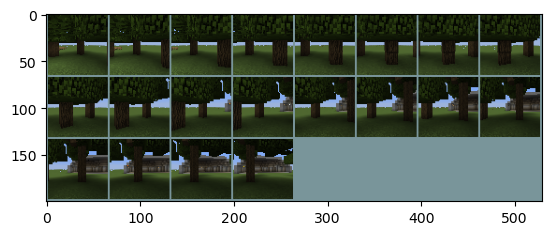

Actual: tensor([ -4.5152,   2.5024, 196.0000], dtype=torch.float64)


In [3]:
import torchvision
from torchvision import transforms
import random

idx = random.randint(0, positions.shape[0])

image_set = images[idx]
position = positions[idx]
action_set = actions[idx]

def show_traj(images):
    mean = [121.6697 / 255, 149.3242 / 255, 154.9510 / 255]
    std = [40.7521 / 255, 47.7267 / 255, 103.2739 / 255]
    
    def imshow(img):
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img * std + mean 
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.show()
    
    imshow(torchvision.utils.make_grid(images))

show_traj(image_set)

print("Actual:", position)

In [6]:
actions.shape

torch.Size([12488, 20, 3])

In [ ]:
# alternate version of the above

from pathlib import Path
import os
from glob import glob
import re

import torch
import torch.optim
import torch.nn.functional as F
from torch.nn import DataParallel

import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from IPython.display import display, clear_output
from PIL import Image
from tqdm.auto import tqdm

from torchvision.io import write_video
from torchvision.transforms import ToTensor, Normalize
from torch import nn
import torch
import torch.nn.functional as F
from glob import glob
import re
import os
from PIL import Image

dataset = 'env-pcs'#'0.1-traj-pcs' #'pc-images'

if dataset == 'pc-images' or 'small-world-random':
    seq_len = 10
    num_actions = 2
else:
    seq_len = 20
    num_actions = 3

seq_len = 50
num_actions = 3

# Set up dataset
folds = glob(f'/home/mag/predictive-coding/datasets/{dataset}/*')
images = []
positions = []
actions = []

# changing this so that the position at each index is actually the prediction for the next image

for idx, fold in enumerate(folds):
    x, y = re.findall(f'/home/mag/predictive-coding/datasets/{dataset}/(.*)_(.*)', fold)[0]
    if dataset == '0.1-traj-pcs':
        trajs = glob(f'/home/mag/predictive-coding/datasets/{dataset}/{x}_{y}/*')
        
        for t, traj in enumerate(trajs):
            action = torch.from_numpy(np.load(f'{traj}/actions.npy'))
            actions.append(action)
            pos = torch.from_numpy(np.load(f'{traj}/states.npy'))
            positions.append(pos)

            for tidx in range(seq_len):
                image = Image.open(f'{traj}/{tidx}.png')
                image = Normalize([121.6697/255, 149.3242/255, 154.9510/255], [40.7521/255,  47.7267/255, 103.2739/255])(ToTensor()(image))
        
                images.append(image)
    else:
        if dataset == 'pc-images' or dataset == 'small-world-random-pc':
            action = torch.from_numpy(np.load(f'{fold}/actions.npy'))
            if len(action) == 0:
                continue
            
            actions.append(action)
            positions.append(torch.from_numpy(np.load(f'{fold}/states.npy')))
        else:
            actions.append(torch.from_numpy(np.load(f'{fold}/actions.npz')['arr_0'])[:-1]) # discard the last action
            positions.append(torch.from_numpy(np.load(f'{fold}/state.npz')['arr_0'])[1:]) # discard the first position -- it won't be predicted

        #images.append(torch.empty(seq_len, 3, 64, 64))
        for tidx in range(seq_len - 1): # the last image has nothing to predict, discard it 
            if not os.path.exists(f'{fold}/{tidx}.png'):
                #images[idx, tidx] = torch.zeros(3, 64, 64)
                print(tidx, x, y)#, yaw)
                continue

            image = Image.open(f'{fold}/{tidx}.png')
            image = Normalize([121.6697/255, 149.3242/255, 154.9510/255], [40.7521/255,  47.7267/255, 103.2739/255])(ToTensor()(image))
        
            images.append(image)

images = torch.stack(images, dim=0)
positions = torch.stack(positions, dim=0).reshape(-1, 3)
actions = torch.stack(actions, dim=0).reshape(-1, num_actions)

tensor([133., 196.,  91., 245., 343., 273., 203.,  63., 238., 210.],
       dtype=torch.float64)

In [3]:
# fix yaw values

for i in range(positions.shape[0]):
    yaw = positions[i, 2] 
    #if yaw < 0:
    #    yaw = 360 + yaw
    positions[i, 2] = np.radians(yaw)

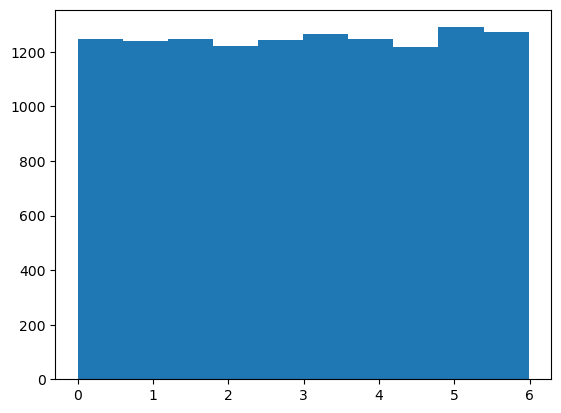

In [4]:
plt.hist(positions[:, 2])
plt.show()


In [ ]:
import numpy as np

from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

import torch

np.random.seed(200)
torch.manual_seed(200)

hds = [0.3, 0.9]

num_actions=3

# they mention in their supplemental info that the encoder does worse than with prediction, so I'm going to do residual 2
# and I'm also going to fix it so that it's the *predicted* location

for hd in hds:
    experiment = f'predictive-coding-{0.1}-{0.1}-{hd}-new-vest'#-{hd}'

    if experiment == 'vgg16':
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES)
    else:
        model = VestibularCoder(
            in_channels=3,
            out_channels=3,
            layers=[2, 2, 2, 2],
            seq_len=20,
            num_actions=num_actions,
            #bottleneck_dim=10
        )
        model.load_state_dict(torch.load(f'./experiments/{experiment}/best.ckpt'))

    model.eval()
    model = model.to('cuda:1')
    
    for i in range(1): # supposed to be residuals but eh
        latents = []
        collected_pos = []
        
        which_residual = 2
        
        bsz = 100
        for idx in range(len(images) // bsz + 1):
            batch = images[bsz*idx:bsz*(idx+1)].to('cuda:1')
            batch_actions = actions[bsz*idx:bsz*(idx+1)].to('cuda:1')
            batch_pos = positions[bsz*idx:bsz*(idx+1)]
            if dataset == 'pc-images' and num_actions == 3:
                zeros = torch.zeros(batch_actions.size(0), seq_len, 1).to('cuda:1')
                batch_actions = torch.cat((batch_actions, zeros), dim=2)
            if dataset != 'pc-images' and num_actions==2:
                batch_actions = batch_actions[:, :, [0, 2]] # reinterpreting the head dir as a move dir, which is not ideal
    
            if len(batch) == 0:
                    break

            with torch.no_grad():
                if experiment == 'vgg16':
                    features = model.features(batch[:, -1])
                    latents.append(features.cpu())
                    collected_pos.append(batch_pos)
                elif experiment == 'autoencoder':
                    features = model.get_latents(batch[:, -1])
                    latents.append(features.cpu())
                    collected_pos.append(batch_pos)
                else:
                    #print(batch.shape)
                    #print(batch_actions.shape)
                    #batch = torch.unsqueeze(batch, 1) # just a sequence of size one to test it coming out of encoder
                    #batch_actions = torch.unsqueeze(batch_actions, 1)
                    features = model.get_latents(batch, actions=batch_actions.float(), which=which_residual)
                    #print(features.shape)
                    latents.append(features.cpu()[:, -1])
                    collected_pos.append(batch_pos)

        latents = torch.cat(latents, dim=0).numpy()
        y = torch.cat(collected_pos, dim=0).numpy()[:, :2]
        X = latents.reshape(latents.shape[0], -1)
        #y = np.copy(positions[:, :2].numpy()

        # Normalize inputs and targets
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        #cos = np.cos(y).reshape(-1, 1)
        #y = np.expand_dims(y, 1)
        #y = np.append(y, cos, 1)
        #y[:, 0] = np.sin(y[:,0])

        y0_mean = y[:, 0].mean()
        y0_std = y[:, 0].std()
        y1_mean = y[:, 1].mean()
        y1_std = y[:, 1].std()
        print('y0 mean and std', y0_mean, y0_std)
        print('y1 mean and std', y1_mean, y1_std)
        y[:, 0] = (y[:, 0] - y0_mean) / y0_std
        y[:, 1] = (y[:, 1] - y1_mean) / y1_std

        svm_model = MultiOutputRegressor(LinearSVR(random_state=0, tol=1e-5, C=0.1, epsilon=0.1))
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
        def denormalize(y, mean, std):
            return y * std + mean
    
        fold_distances = []
    
        for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]
    
            svm_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = svm_model.predict(X_val_fold)
    
            # Denormalize
            y_val_denorm = np.copy(y_val_fold)
            y_val_denorm[:, 0] = denormalize(y_val_denorm[:, 0], y0_mean, y0_std)
            y_val_denorm[:, 1] = denormalize(y_val_denorm[:, 1], y1_mean, y1_std)
    
            y_pred_denorm = np.copy(y_pred_fold)
            y_pred_denorm[:, 0] = denormalize(y_pred_denorm[:, 0], y0_mean, y0_std)
            y_pred_denorm[:, 1] = denormalize(y_pred_denorm[:, 1], y1_mean, y1_std)
    
            # Calculate distances
            distances = np.linalg.norm(y_pred_denorm - y_val_denorm, axis=1)
            fold_distances.append(distances)
    
            print(f"Fold {fold+1} - Mean distance error: {distances.mean():.4f}")
        
        all_distances = np.concatenate(fold_distances)
        mean_distance = np.mean(all_distances)
        median_distance = np.median(all_distances)
        std_distance = np.std(all_distances)

        print(f"Overall Mean distance error: {mean_distance:.4f}")
        print(f"Overall Median distance error: {median_distance:.4f}")
        print(f"Standard deviation of distance error: {std_distance:.4f}")
    
        # Fit the model on the entire dataset for final evaluation and saving
        svm_model.fit(X, y)

        np.save(f'./experiments/{experiment}/position_errors-residual-2-linear-svm.npy', all_distances)
        
        from pickle import dump
        with open(f'./experiments/{experiment}/position_decoder-residual-2-linear-svm.pkl', "wb") as f:
            dump(svm_model, f, protocol=5)
        
        with open(f'./experiments/{experiment}/position_decoder-residual-2-linear-svm-scaler.pkl', 'wb') as f:
            dump(scaler, f)

y0 mean and std -0.061694127590437874 11.802205151358915
y1 mean and std -0.045899637064954396 18.41252271402133


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold 1 - Mean distance error: 6.7736


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold 2 - Mean distance error: 6.7150


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold 3 - Mean distance error: 6.6989


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold 4 - Mean distance error: 6.8422


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold 5 - Mean distance error: 6.8779
Overall Mean distance error: 6.7815
Overall Median distance error: 6.0468
Standard deviation of distance error: 4.3807


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

import torch

from torchvision.models import vgg16, VGG16_Weights

np.random.seed(200)
torch.manual_seed(200)

hds = [0.1, 0.5, 0.9]

num_actions=2

for hd in hds:
    experiment = f'predictive-coding-{hd}-{hd}-new-vest'#-{hd}'

    if experiment == 'vgg16':
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES)
    else:
        model = VestibularCoder(
            in_channels=3,
            out_channels=3,
            layers=[2, 2, 2, 2],
            seq_len=20,
            num_actions=num_actions,
            #bottleneck_dim=10
        )
        model.load_state_dict(torch.load(f'./experiments/{experiment}/best.ckpt'))

    model.eval()
    model = model.to('cuda:1')
    
    for i in range(1): # supposed to be residuals but eh
        latents = []
        collected_pos = []
        
        which_residual = 2
        
        bsz = 100
        for idx in range(len(images) // bsz + 1):
            batch = images[bsz*idx:bsz*(idx+1)].to('cuda:1')
            batch_actions = actions[bsz*idx:bsz*(idx+1)].to('cuda:1')
            batch_pos = positions[bsz*idx:bsz*(idx+1)]
            if dataset == 'pc-images' and num_actions == 3:
                zeros = torch.zeros(batch_actions.size(0), seq_len, 1).to('cuda:1')
                batch_actions = torch.cat((batch_actions, zeros), dim=2)
            if dataset != 'pc-images' and num_actions==2:
                batch_actions = batch_actions[:, :, [0, 2]] # reinterpreting the head dir as a move dir, which is not ideal
    
            if len(batch) == 0:
                    break

            with torch.no_grad():
                if experiment == 'vgg16':
                    features = model.features(batch[:, -1])
                    latents.append(features.cpu())
                    collected_pos.append(batch_pos)
                elif experiment == 'autoencoder':
                    features = model.get_latents(batch[:, -1])
                    latents.append(features.cpu())
                    collected_pos.append(batch_pos)
                else:
                    #batch = torch.unsqueeze(batch, 1) # just a sequence of size one to test it coming out of encoder
                    #batch_actions = torch.unsqueeze(batch_actions, 1)
                    features = model.get_latents(batch, actions=batch_actions.float(), which=which_residual)
                    #print(features.shape)
                    latents.append(features.cpu()[:, -1])
                    collected_pos.append(batch_pos)

        latents = torch.cat(latents, dim=0).numpy()
        y = torch.cat(collected_pos, dim=0).numpy()[:, :2]
        X = latents.reshape(latents.shape[0], -1)
        #y = np.copy(positions[:, :2].numpy()

        # Normalize inputs and targets
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        #cos = np.cos(y).reshape(-1, 1)
        #y = np.expand_dims(y, 1)
        #y = np.append(y, cos, 1)
        #y[:, 0] = np.sin(y[:,0])

        del model

        y0_mean = y[:, 0].mean()
        y0_std = y[:, 0].std()
        y1_mean = y[:, 1].mean()
        y1_std = y[:, 1].std()
        print('y0 mean and std', y0_mean, y0_std)
        print('y1 mean and std', y1_mean, y1_std)
        y[:, 0] = (y[:, 0] - y0_mean) / y0_std
        y[:, 1] = (y[:, 1] - y1_mean) / y1_std

        svm_model = MultiOutputRegressor(LinearSVR(random_state=0, tol=1e-5, C=0.1, epsilon=0.1))
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
        def denormalize(y, mean, std):
            return y * std + mean
    
        fold_distances = []
    
        for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]
    
            svm_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = svm_model.predict(X_val_fold)
    
            # Denormalize
            y_val_denorm = np.copy(y_val_fold)
            y_val_denorm[:, 0] = denormalize(y_val_denorm[:, 0], y0_mean, y0_std)
            y_val_denorm[:, 1] = denormalize(y_val_denorm[:, 1], y1_mean, y1_std)
    
            y_pred_denorm = np.copy(y_pred_fold)
            y_pred_denorm[:, 0] = denormalize(y_pred_denorm[:, 0], y0_mean, y0_std)
            y_pred_denorm[:, 1] = denormalize(y_pred_denorm[:, 1], y1_mean, y1_std)
    
            # Calculate distances
            distances = np.linalg.norm(y_pred_denorm - y_val_denorm, axis=1)
            fold_distances.append(distances)
    
            print(f"Fold {fold+1} - Mean distance error: {distances.mean():.4f}")
        
        all_distances = np.concatenate(fold_distances)
        mean_distance = np.mean(all_distances)
        median_distance = np.median(all_distances)
        std_distance = np.std(all_distances)

        print(f"Overall Mean distance error: {mean_distance:.4f}")
        print(f"Overall Median distance error: {median_distance:.4f}")
        print(f"Standard deviation of distance error: {std_distance:.4f}")
    
        # Fit the model on the entire dataset for final evaluation and saving
        svm_model.fit(X, y)

        np.save(f'./experiments/{experiment}/position_errors-residual-2-linear-svm.npy', all_distances)
        
        from pickle import dump
        with open(f'./experiments/{experiment}/position_decoder-residual-2-linear-svm.pkl', "wb") as f:
            dump(svm_model, f, protocol=5)
        
        with open(f'./experiments/{experiment}/position_decoder-residual-2-linear-svm-scaler.pkl', 'wb') as f:
            dump(scaler, f)

In [4]:
from pathlib import Path
import os
from glob import glob
import re

# Collect training population statistics
#dataset = 'small-world-random' 
dataset = 'random-dataset-0.1-0.1'

# Set up dataset
folds = glob(f'/home/mag/malmo/datasets/{dataset}/train/*')
train_positions = []

for idx, fold in enumerate(folds):
    train_positions.append(np.load(f'{fold}/state.npz')['arr_0'])

train_positions = np.stack(positions).reshape(-1, 3)

def bin_coord(coord, bin_size=1):
    signs = np.sign(coord)
    binned = np.floor(np.abs(coord) / bin_size) * bin_size
    binned *= signs
    binned += (bin_size / 2) * signs
    return binned

binned_coords = [bin_coord(coord) for coord in train_positions[:, :2]]
binned_coords = np.stack(binned_coords)

locations, frequencies = np.unique(binned_coords, return_counts=True, axis=0)

probabilities = frequencies / np.sum(frequencies)
sampled_indices = np.random.choice(len(locations), size=len(locations), p=probabilities)
predictions = locations[sampled_indices]

chance_errors = np.linalg.norm(predictions - locations, axis=1)

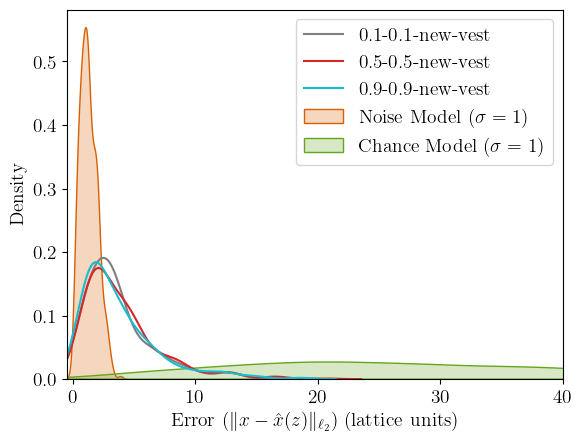

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from predictive_coding.analysis import *
import matplotlib as mpl

plt.style.use("~/predictive-coding-recovers-maps/thesis.mplstyle")

pt = 1./72.27
my_width = 433.62
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

#fig = plt.figure(figsize = (my_width, my_width/golden))

plt.rcParams.update({'font.size': 14})

def error_histogram(
    errors: List[np.ndarray],
    labels: list[str],
    colors: List[Color],
) -> Figure:
    fig = plt.figure() #(figsize = (my_width*0.1, 0.1*my_width/golden))

    for error, label, color in zip(errors, labels, colors):
        #sns.histplot(error, kde=True, stat="density", label=label, color=color)
        sns.kdeplot(error, fill=False, label=label, color=color)

    plt.xlabel("Error ($\Vert x - \hat{x}(z) \Vert_{\ell_2}$) (lattice units)")
    plt.legend()

    return fig

experiments = [
#'0.1-0.1-0.0',
#'0.1-0.1-0.3', 
#'0.1-0.1-0.9',
#'0.1-0.1',
#'0.5-0.5',
#'0.9-0.9',
#'replicate-more-random-10-steps',
'0.1-0.1-new-vest',
'0.5-0.5-new-vest',
'0.9-0.9-new-vest',
#    '0.1-0.1-0.0-new-vest',
#    '0.1-0.1-0.3-new-vest',
#    '0.1-0.1-0.9-new-vest',
#'mixed-randomness'
    #'vgg16',
    #'predictive-coding-small-world-random'
    #'predictive-coding-0.1-0.1',
    #'predictive-coding-0.1-0.1-10d-bottleneck'
]

residual = 2

#errors = [np.load(f'./experiments/predictive-coding-{ex}/position_errors-residual-2-linear-svm.npy') for ex in experiments]
errors = [np.load(f'./experiments/predictive-coding-{ex}/position_errors-residual-2-nonlinear-multiview.npy') for ex in experiments]
#errors = [np.load('./experiments/predictive-coding-0.1-0.1/position_errors-residual-0-nonlinear-multiview.npy'),
#         #np.load('./experiments/predictive-coding-0.1-0.1-vestibular/position_errors-residual-2-linear-svm.npy')]#,
#         np.load('./experiments/predictive-coding-0.1-0.1/position_errors-residual-2-nonlinear-multiview.npy')]
#         np.load('./experiments/autoencoder/position_errors-big-world-residual-2-linear-svm.npy')]
#errors = [np.load(f'./experiments/vgg16/position_errors-residual-{i}-linear-svm.npy') for i in range(1)]

#error = np.load('./experiments/predictive-coding-0.1-0.1-0.0/position_errors.npy') #position_decoder.error(latents)
noise = np.linalg.norm(np.random.randn(len(errors[0]), 2), axis=1)

error_histogram(
errors, 
experiments, #['Pre-Attention Pred-Code', 'Pred-Code'], #[ex[:3] + ' Predictive Coder' for ex in experiments],
[plt.cm.tab10(7), plt.cm.tab10(3), plt.cm.tab10(10)] #[plt.cm.tab10(i+7) for i in range(len(errors))]
)
sns.kdeplot(noise, fill=True, label="Noise Model ($\sigma=1$)", color=plt.cm.Dark2(1))
sns.kdeplot(chance_errors, fill=True, label="Chance Model ($\sigma=1$)", color=plt.cm.Dark2(4))

ax = plt.gca()
ax.set_xlim([-0.5, 40]) # for position
#ax.set_xlim([-0.5, 6]) # for yaw

plt.legend()
#plt.title(f")
plt.savefig(f'./experiments/nonlinear-position-decoder-comparison-new-vest.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close()


In [ ]:
import torch
import gc

from torchvision.models import vgg16, VGG16_Weights

sets = [(0.5, 0.5)]#, (0.9, 0.9), (0.1, 0.1, 0.0), (0.1, 0.1, 0.3), (0.1, 0.1, 0.9)]

for set in sets:

    set_string = '-'.join(list(map(str, set)))
    experiment = f'predictive-coding-{set_string}'  #{hd}-{hd}'
    
    model = PredictiveCoder(
        in_channels=3,
        out_channels=3,
        layers=[2, 2, 2, 2],
        seq_len=20,
        #num_actions=len(set),
    )
    model.load_state_dict(torch.load(f'./experiments/{experiment}/best.ckpt'))
    
    model.eval()
    model = model.to('cuda:1')
    
    latents = []
    locations = []
    which_residual = 2
        
    bsz = 100
    for idx in range(len(images) // bsz + 1):
        batch = images[bsz*idx:bsz*(idx+1)].to('cuda:1')
        batch_actions = actions[bsz*idx:bsz*(idx+1)].to('cuda:1')
        batch_positions = positions[bsz*idx:bsz*(idx+1)]
        if len(set) == 2:
            batch_actions = batch_actions[:, :, [0, 2]] # for the vestibular non head turn models
    
        if len(batch) == 0:
            break
                    
        with torch.no_grad():
            features = model.get_latents(batch, actions=batch_actions.float(), which=which_residual)[:, -1]
            latents.append(features.cpu())
    
        locations.append(batch_positions)
    
    gc.collect()
    torch.cuda.empty_cache()
                    
    latents = torch.cat(latents, dim=0)
    locations = torch.cat(locations, dim=0)[:, :2]
    
    y0_mean = locations[:, 0].mean()
    y0_std = locations[:, 0].std()
    y1_mean = locations[:, 1].mean()
    y1_std = locations[:, 1].std()
    print('y0 mean and std', y0_mean, y0_std)
    print('y1 mean and std', y1_mean, y1_std)
    locations[:, 0] = (locations[:, 0] - y0_mean) / y0_std
    locations[:, 1] = (locations[:, 1] - y1_mean) / y1_std
    
    shuffle = torch.randperm(len(latents))
    latents = latents[shuffle]
    locations = locations[shuffle]
    val_latents = latents[:400] 
    train_latents = latents[400:]
    val_positions = locations[:400]
    train_positions = locations[400:]

    net = ImprovedNet()

    net = net.to("cuda:1")
            
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

    batch_size = 512
    for epoch in tqdm(range(500)):
        batch_idx = np.arange(0, len(train_latents))
        np.random.shuffle(batch_idx)
        batch_idx = batch_idx[:len(batch_idx) // batch_size * batch_size].reshape(-1, batch_size)
        model.train()
        for it, idx in enumerate(batch_idx):
            optimizer.zero_grad()
            batch = train_latents[idx].float().to("cuda:1")
            pos = train_positions[idx, :2].float().to("cuda:1")
            pred = net(batch)
            loss = F.mse_loss(pred, pos)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            pred = net(val_latents.to("cuda:1")).cpu()
            print(F.mse_loss(pred, val_positions), end='\r')
        scheduler.step()
    
    with torch.no_grad():
        batch = val_latents.to("cuda:1")
        pc_pred = net(batch).cpu()
        pc_pred[:, 0] = pc_pred[:, 0] * y0_std + y0_mean
        pc_pred[:, 1] = pc_pred[:,1] * y1_std + y1_mean
        
        validation = torch.clone(val_positions)
        validation[:, 0] = validation[:,0] * y0_std + y0_mean
        validation[:, 1] = validation[:,1] * y1_std + y1_mean
        pc = torch.linalg.norm(pc_pred - validation, dim=1).cpu().numpy()

    
    print(f"Finished processing {experiment}-residual-{which_residual}")
    np.save(f'./experiments/{experiment}/position_errors-residual-{which_residual}-nonlinear-multiview.npy', pc)
    torch.save(net.state_dict(), f'./experiments/{experiment}/position-decoder-residual-{which_residual}-nonlinear-multiview.pth')

    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
class ImprovedNet(nn.Module):
    def __init__(self, input_channels=128, output_dim=2):
        super(ImprovedNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 256, 3, padding=1)
        self.conv2 = nn.Conv2d(256, 512, 3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, output_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [15]:
class ImprovedNet(nn.Module):
    def __init__(self, input_channels=256, output_dim=2):
        super(ImprovedNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 512, 3, padding=1)
        self.conv2 = nn.Conv2d(512, 1024, 3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, output_dim)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

for i in range(1):

    net = ImprovedNet()

    net = net.to("cuda:1")
            
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

    batch_size = 512
    for epoch in tqdm(range(500)):
        batch_idx = np.arange(0, len(train_latents))
        np.random.shuffle(batch_idx)
        batch_idx = batch_idx[:len(batch_idx) // batch_size * batch_size].reshape(-1, batch_size)
        model.train()
        for it, idx in enumerate(batch_idx):
            optimizer.zero_grad()
            batch = train_latents[idx].float().to("cuda:1")
            pos = train_positions[idx, :2].float().to("cuda:1")
            pred = net(batch)
            loss = F.mse_loss(pred, pos)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            pred = net(val_latents.to("cuda:1")).cpu()
            print(F.mse_loss(pred, val_positions), end='\r')
        scheduler.step()

    model.eval()
    with torch.no_grad():
        batch = val_latents.to("cuda:1")
        pc_pred = net(batch).cpu()
        pc_pred[:, 0] = pc_pred[:, 0] * y0_std + y0_mean
        pc_pred[:, 1] = pc_pred[:,1] * y1_std + y1_mean
        
        validation = torch.clone(val_positions)
        validation[:, 0] = validation[:,0] * y0_std + y0_mean
        validation[:, 1] = validation[:,1] * y1_std + y1_mean
        pc = torch.linalg.norm(pc_pred - validation, dim=1).cpu().numpy()

    
    print(f"Finished processing {experiment}-residual-{which_residual}")
    np.save(f'./experiments/{experiment}/position_errors-residual-{which_residual}-nonlinear-multiview.npy', pc)
    torch.save(net.state_dict(), f'./experiments/{experiment}/position-decoder-residual-{which_residual}-nonlinear-multiview.pth')

    gc.collect()
    torch.cuda.empty_cache()
    

  0%|          | 0/500 [00:00<?, ?it/s]

Finished processing predictive-coding-0.1-0.1-new-vest-residual-2


In [10]:
with torch.no_grad():
    batch = val_latents.to("cuda:1")
    pc_pred = net(batch).cpu()
    pc_pred[:, 0] = pc_pred[:, 0] * y0_std + y0_mean
    pc_pred[:, 1] = pc_pred[:,1] * y1_std + y1_mean
        
    validation = torch.clone(val_positions)
    validation[:, 0] = validation[:,0] * y0_std + y0_mean
    validation[:, 1] = validation[:,1] * y1_std + y1_mean
    pc = torch.linalg.norm(pc_pred - validation, dim=1).cpu().numpy()

    
print(f"Finished processing {experiment}-residual-{which_residual}")
np.save(f'./experiments/{experiment}/position_errors-residual-{which_residual}-nonlinear-multiview.npy', pc)
torch.save(net.state_dict(), f'./experiments/{experiment}/position-decoder-residual-{which_residual}-nonlinear-multiview.pth')

gc.collect()
torch.cuda.empty_cache()

Finished processing predictive-coding-0.1-0.1-new-vest-residual-0


In [19]:
# Load the trained linear svm 

from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from pickle import load
from sklearn.preprocessing import StandardScaler
from functools import reduce

experiment = 'predictive-coding-0.1-0.1-0.0'

residuals = list(range(3))

n = 1000
top_n = []

for residual in residuals:
    with open(f"./experiments/{experiment}/yaw_decoder-residual-{residual}-linear-svm.pkl", "rb") as f:
        position_decoder = load(f)    
    
    importances = []
    for estimator in position_decoder.estimators_:
        importances.append(np.abs(estimator.coef_))
    
    importances = np.array(importances)
    aggregated_importances = np.mean(importances, axis=0)  # or np.max(importances, axis=0)
    indices = np.argsort(aggregated_importances)[::-1]
    
    # Print top N most important features
    #N = 30  # for example
    #print(f"Top {N} most important units:")
    #for f, idx in enumerate(indices[:N]):
    #    print(f"{f+1}. Unit {idx}: {aggregated_importances[idx]:.4f}")
    
    threshold = 0.005
    significant_units = sum(aggregated_importances > threshold)
    print(f"{significant_units}/{len(aggregated_importances)} units significantly encode yaw in residual {residual}")

    # Store top n units
    top_n.append(indices[:n])

print(f"\nNum overlap in top {n} for {experiment} (yaw decoder):")
print(f"between 0 and 1 residual: {np.intersect1d(top_n[0], top_n[1]).shape[0]}")
print(f"between 1 and 2 residual: {np.intersect1d(top_n[1], top_n[2]).shape[0]}")
print(f"between 0 and 2 residual: {np.intersect1d(top_n[0], top_n[2]).shape[0]}")
all = reduce(np.intersect1d, top_n)
print(f"between all residuals: {len(all)}")

#print(all)

2438/8192 units significantly encode yaw in residual 0
5480/8192 units significantly encode yaw in residual 1
6296/8192 units significantly encode yaw in residual 2

Num overlap in top 1000 for predictive-coding-0.1-0.1-0.0 (yaw decoder):
between 0 and 1 residual: 177
between 1 and 2 residual: 193
between 0 and 2 residual: 142
between all residuals: 42


In [5]:
# basically the same but we're gonna look at coding between vestibular models
# Load the trained linear svm 

from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from pickle import load
from sklearn.preprocessing import StandardScaler
from functools import reduce

sets = ['0.1-0.1', '0.1-0.1-0.0', '0.1-0.1-0.3', '0.1-0.1-0.9']

n = 1000
top_n = []

threshold = 0.001
r = 2

print(f"With a threshold of {threshold}... for residual {r}")

for set in sets:
    for vest in range(1):
        vest = 1
        experiment = f'predictive-coding-{set}-vestibular' if vest else f'predictive-coding-{set}'
        
        with open(f"./experiments/{experiment}/position_decoder-residual-{r}-linear-svm.pkl", "rb") as f:
            position_decoder = load(f)    
        
        # Get feature importances
        importances = []
        for estimator in position_decoder.estimators_:
            importances.append(np.abs(estimator.coef_))
        
        # Convert to numpy array for easier manipulation
        importances = np.array(importances)
        
        # Aggregate importances across dimensions (e.g., using mean or max)
        aggregated_importances = np.mean(importances, axis=0)  # or np.max(importances, axis=0)
        
        # Sort features by importance
        indices = np.argsort(aggregated_importances)[::-1]
        
        # Print top N most important features
        #N = 30  # for example
        #print(f"Top {N} most important units:")
        #for f, idx in enumerate(indices[:N]):
        #    print(f"{f+1}. Unit {idx}: {aggregated_importances[idx]:.4f}")
        
        # Count 'significant' units (e.g., those with importance above a threshold)
        #np.mean(aggregated_importances) + np.std(aggregated_importances)  # for example
        significant_units = sum(aggregated_importances > threshold)
        print(f"{significant_units}/{len(aggregated_importances)} units significantly encode place in set {set} (vest = {bool(vest)})")
    
        # Store top n units
        top_n.append(indices[:n])
    print()



With a threshold of 0.001... for residual 2
1994/8192 units significantly encode place in set 0.1-0.1 (vest = True)

1141/8192 units significantly encode place in set 0.1-0.1-0.0 (vest = True)

1668/8192 units significantly encode place in set 0.1-0.1-0.3 (vest = True)

1968/8192 units significantly encode place in set 0.1-0.1-0.9 (vest = True)



In [ ]:
# Comparing between the yaw and position models

# Load the trained linear svm 

from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from pickle import load
from sklearn.preprocessing import StandardScaler
from functools import reduce

experiment = 'predictive-coding-0.1-0.1-0.0'

residual = 0

n = 5000
top_n = []

with open(f"./experiments/{experiment}/yaw_decoder-residual-{residual}-linear-svm.pkl", "rb") as f:
    yaw_decoder = load(f)  

with open(f"./experiments/{experiment}/place_decoder-residual-{residual}-linear-svm.pkl", "rb") as f:
    position_decoder = load(f)    
    
place_importances = []
for estimator in position_decoder.estimators_:
    place_importances.append(np.abs(estimator.coef_))

yaw_importances = []
for estimator in yaw_decoder.estimators_:
    importances.append(np.abs(estimator.coef_))

# set a threshold for both models and then use that threshold for the non head turn model

# take the top n of each, then get non-overlapping units
yaw_importances = np.array(yaw_importances)
aggregated_importances = np.mean(yaw_importances, axis=0) 
top_n_yaw = np.argsort(aggregated_importances)[::-1][:n]

place_importances = np.array(place_importances)
aggregated_importances = np.mean(place_importances, axis=0) 
top_n_place = np.argsort(aggregated_importances)[::-1][:n]

yaw_threshold = np.percentile(top_n_yaw, 90)
place_threshold = np.percentile(top_n_place, 90)

print(f"For the head turn model, taking {yaw_threshold} as the yaw threshold and {place_threshold} as the place threshold")

# also need to look at the overlap between yaw selective and non-yaw selective models

threshold = 0.004
significant_units = sum(aggregated_importances > threshold)
print(f"{significant_units}/{len(aggregated_importances)} units significantly encode yaw in residual {residual}")

# Store top n units
top_n.append(indices[:n])
